In [ ]:
class DecisionStump:
    
    def __init__(self):
        
    def fit(self, X, y, criterion, weights):
        
    def predict(self, X):
        

In [57]:
def precision_recall_f1(preds, truth):
    tp, fp, tn, fn = 0, 0, 0, 0
    for j in range(len(preds)):
        if truth[j] == 1 and preds[j] == 1:
            tp += 1
        elif truth[j] == 1:
            fn += 1
        elif preds[j] == 1:
            fp += 1
        else:
            tn += 1
    if tp + fp > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
    recall = tp / (tp + fn)
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else: 
        f1 = 0
    return (precision, recall, f1)

In [58]:
import numpy as np
import pandas as pd
import copy
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics

In [82]:
# Metric: choice of evaluation metric (f1, precision, recall, etc.)
# Proportion: proportion of test set to predict as 1s, if needed (logistic regression may predict all 0 by default)
def my_cross_val_imbalanced(model, metric, proportion, X, y, k=10):
    (n, d) = X.shape
    validation_metrics = np.zeros(k)
    for i in range(k):
        val_set = X[round(i*n/k):round((i+1)*n/k), :]
        val_labels = y[round(i*n/k):round((i+1)*n/k)]
        train_set = np.delete(X, [j for j in range(round(i*n/k), round((i+1)*n/k))], 0)
        train_labels = np.delete(y, [j for j in range(round(i*n/k), round((i+1)*n/k))], 0)
        model.fit(train_set, train_labels)
        if proportion == None:
            y_preds = model.predict(val_set)
        else:
            y_preds = model.predict_proportion(val_set, proportion)
        
        tp, fp, tn, fn = 0, 0, 0, 0
        score = 0
        for j in range(len(y_preds)):
            if val_labels[j] == 1 and y_preds[j] == 1:
                tp += 1
            elif val_labels[j] == 1:
                fn += 1
            elif y_preds[j] == 1:
                fp += 1
            else:
                tn += 1
        if tp == 0: # to avoid division by zero error for trivial models
            precision = 0
            recall = 0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)  
        if metric == 'precision':
            score = precision
        if metric == 'recall':
            score = recall
        if metric == 'f1':
            if precision + recall == 0:
                score = 0
            else:
                score = 2 * precision * recall / (precision + recall)
        if metric == 'auprc':
            score = sklearn.metrics.average_precision_score(val_labels, y_preds)
        validation_metrics[i] = score
    return validation_metrics

In [59]:
class MyAdaboost:
    
    def __init__(self, estimator, num_estimators):
        
        self.estimator=estimator # just declaring the type of estimator! do not change it but make copies
        self.num_estimators=num_estimators
        self.classifiers = []
        self.alphas = []
        
    def fit(self, X, y): # y labeled in 1 and -1 (make sure to do that before!)
        
        (n, d) = X.shape
        weights = np.array([(1/n) for i in range(n)])
        adaboost_predictions = np.zeros(n)
        
        
        for t in range(self.num_estimators):
            
            #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=t)
            estimator = copy.deepcopy(self.estimator)
            
            #generating dataset to fit from weight distribution
            samples = np.random.choice(np.array(range(n)), size=n, replace=True, p=weights)
            X_samp = X[samples]
            y_samp = y[samples]
            
            estimator.fit(X_samp, y_samp)
            print(np.argmax(estimator.feature_importances_)) # prints most important column, also add in dataframe to figure out what it is???
            predictions = estimator.predict(X) #do you just do the training set here?
            
            error = 0
            for i in range(n):
                if predictions[i] != y[i]: # introduce parameter here to add extra class weight for when y = 1?
                    error += weights[i] 
            #error = error / (np.sum(weights))

            alpha = (1/2)*np.log((1 - error)/error)
            
            for i in range(n):
                if predictions[i] != y[i]: #same here introduce some weight...
                    weights[i] *= np.exp(alpha)
                else:
                    weights[i] *= np.exp(-alpha)
            
            #Normalize weights
            weights = weights/np.sum(weights)
            
            self.classifiers.append(estimator)
            self.alphas.append(alpha)
            
            # Add weak classifier weights 
            #self.classifiers.append(alpha*predictions)
        #print(self.classifiers)
        #print(self.alphas)
        
    def predict(self, X):
        (n, d) = X.shape
        predictions = np.zeros(n)
        for t in range(self.num_estimators):
            predictions += self.alphas[t] * self.classifiers[t].predict(X)
        print(predictions)
        return np.sign(predictions)

In [85]:
class MyWeightedAdaboost:
    
    def __init__(self, estimator, num_estimators, w1):
        
        self.estimator=estimator # just declaring the type of estimator! do not change it but make copies
        self.num_estimators=num_estimators
        self.classifiers = []
        self.alphas = []
        self.w1 = w1
        
    def fit(self, X, y): # y labeled in 1 and -1 (make sure to do that before!)
        
        (n, d) = X.shape
        weights = np.array([(1/n) for i in range(n)])
        adaboost_predictions = np.zeros(n)
        
        # Initializing extra weight for ones
        one_indices = np.where(y==1)
        weights[one_indices] *= self.w1
        weights = weights/np.sum(weights)
        
        for t in range(self.num_estimators):
            
            #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=t)
            estimator = copy.deepcopy(self.estimator)
            
            #generating dataset to fit from weight distribution
            samples = np.random.choice(np.array(range(n)), size=n, replace=True, p=weights)
            X_samp = X[samples]
            y_samp = y[samples]
            
            estimator.fit(X_samp, y_samp)
            print(np.argmax(estimator.feature_importances_)) # prints most important column, also add in dataframe to figure out what it is???
            predictions = estimator.predict(X) #do you just do the training set here?
            
            error = 0
            for i in range(n):
                if predictions[i] != y[i]: # introduce parameter here to add extra class weight for when y = 1?
                    error += weights[i] 
            #error = error / (np.sum(weights))

            alpha = (1/2)*np.log((1 - error)/error)
            
            for i in range(n):
                if predictions[i] != y[i]: #same here introduce some weight...
                    weights[i] *= np.exp(alpha)
                else:
                    weights[i] *= np.exp(-alpha)
            
            #Normalize weights
            weights = weights/np.sum(weights)
            
            self.classifiers.append(estimator)
            self.alphas.append(alpha)
            
            # Add weak classifier weights 
            #self.classifiers.append(alpha*predictions)
        #print(self.classifiers)
        #print(self.alphas)
        
    def predict(self, X):
        (n, d) = X.shape
        predictions = np.zeros(n)
        for t in range(self.num_estimators):
            predictions += self.alphas[t] * self.classifiers[t].predict(X)
        print(predictions)
        return np.sign(predictions)
    
    def predict_values(self, X):
        (n, d) = X.shape
        predictions = np.zeros(n)
        for t in range(self.num_estimators):
            predictions += self.alphas[t] * self.classifiers[t].predict(X)
        #print(predictions)
        return predictions
    
    def predict_proportion(self, X, prop):
        (n, d) = X.shape
        predictions = np.zeros(n)
        for t in range(self.num_estimators):
            predictions += self.alphas[t] * self.classifiers[t].predict(X)
        threshold = np.quantile(predictions, 1-prop)
        preds = np.zeros(n)
        for i in range(len(preds)):
            if predictions[i] >= threshold:
                preds[i] = 1
            else:
                preds[i] = -1
        return preds

In [ ]:
# Add a general oversample (smote) function? See how it performs across all algs?
def smote(data, categoricals):
    

In [61]:
train_data = pd.read_csv('aug_train.csv')
test_data = pd.read_csv('aug_test.csv')
y_test = np.load('answer.npy')
train_samples = len(train_data)
test_samples = len(test_data)
data = pd.concat([train_data, test_data])
data = pd.get_dummies(data, columns=['Gender', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel'])

In [62]:
data.loc[data['Response'] == 0, 'Response'] = -1 # changing negative class to -1 for adaboost to work

In [63]:
data

,id,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage,Response,Gender_Female,Gender_Male,Region_Code_0.0,...,Policy_Sales_Channel_152.0,Policy_Sales_Channel_153.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0
0,167647,22,1,1,2630.0,16,-1.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,17163,42,1,0,43327.0,135,-1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,32023,66,1,0,35841.0,253,-1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,87447,22,1,0,27645.0,69,-1.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,501933,28,1,1,29023.0,211,-1.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78268,847,43,1,0,2630.0,26,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
78269,417524,21,1,1,32937.0,185,NaN,1,0,0,...,1,0,0,0,0,0,0,0,0,0
78270,188087,48,1,1,35247.0,101,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0
78271,215680,64,1,1,25705.0,86,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
train_data = data.iloc[0:train_samples]
test_data = data.iloc[train_samples:]
test_data = test_data.drop('Response', axis=1)

train_data = train_data.drop('id', axis=1)
test_data = test_data.drop('id', axis=1)

X_train = train_data.drop('Response', axis=1)
y_train = train_data['Response']
X_test = test_data

In [65]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()

In [36]:
adaboost = MyAdaboost(DecisionTreeClassifier(max_depth=1), 50)

adaboost.fit(X_train, y_train)

y_preds = adaboost.predict(X_test)

# compute F1 score on test data
(precision, recall, f1) = precision_recall_f1(y_preds, y_test)

print("Test precision: " + str(precision))
print("Test recall: " + str(recall))
print("Test F1 score: " + str(f1))

62
63
2
2
2
2
0
0
2
2
2
2
0
0
210
210
2
2
0
0
218
218
2
2
218
218
2
2
218
218
0
210
210
218
218
218
218
218
88
0
218
0
2
0
0
218
2
218
218
218
[-3.33309778 -0.3906584  -3.20019283 ... -3.33309778 -3.84203324
 -4.0756106 ]
Test precision: 0.5257711831315892
Test recall: 0.2100951786550164
Test F1 score: 0.30022296544035676


In [67]:
w1_vals = [1, 2, 5, 10, 20, 50]

for w in w1_vals:

    adaboost = MyWeightedAdaboost(DecisionTreeClassifier(max_depth=1), 50, w)

    adaboost.fit(X_train, y_train)

    y_preds = adaboost.predict(X_test)

    # compute F1 score on test data
    (precision, recall, f1) = precision_recall_f1(y_preds, y_test)

    print("Test precision: " + str(precision))
    print("Test recall: " + str(recall))
    print("Test F1 score: " + str(f1))

63


KeyboardInterrupt: 

In [68]:
w1_vals = [1, 2, 5, 10, 20, 50]


for w in w1_vals:

    adaboost = MyWeightedAdaboost(DecisionTreeClassifier(max_depth=1), 50, w)

    adaboost.fit(X_train, y_train)

    y_preds = adaboost.predict_proportion(X_test)

    # compute F1 score on test data
    (precision, recall, f1) = precision_recall_f1(y_preds, y_test)
    auprc = sklearn.metrics.average_precision_score(y_test, y_preds)

    print("Test precision: " + str(precision))
    print("Test recall: " + str(recall))
    print("Test F1 score: " + str(f1))
    print("Test AUPRC score: " + str(auprc)) 

64
64
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
2
0
2
2
219
219
219
219
0
2
0
2
2
219
219
211
219
219
219
2
89
0
219
219
219
219
2
2
219
219
211
219
[-3.34671582 -0.39863218 -3.19331374 ... -3.34671582 -3.82219926
 -4.0799194 ]
Test precision: 0.5257711831315892
Test recall: 0.2100951786550164
Test F1 score: 0.30022296544035676
Test AUPRC score: 0.23981694063444325
63
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
64
64
0
0
219
219
219
219
0
2
2
219
219
211
219
219
219
219
2
0
89
0
2
2
219
219
2
2
219
219
64
35
0
[-2.93991918  0.01585666 -2.67606483 ... -2.93991918 -3.40367646
 -3.67546675]
Test precision: 0.4698866751964906
Test recall: 0.8022312373225152
Test F1 score: 0.5926459570053599
Test AUPRC score: 0.409344415580666
64
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
0
2
0
219
219
219
219
2
2
219
219
0
0
211
211
219
219
219
219
0
0
89
2
219
219
0
0
0
0
219
219
219
219
[-2.53743124  0.43795351 -2.38790045 ... -2.53743124 -2.95478425
 -3.27418324]
Test precision: 0.39396893481510364
Test recall: 0.9458573880

In [83]:
w1_vals = [1, 2, 5, 10, 20, 50]

best_score = 0
best_weight = 0

for w in w1_vals:

    adaboost = MyWeightedAdaboost(DecisionTreeClassifier(max_depth=1), 50, w)

    cv_scores = my_cross_val_imbalanced(adaboost, 'f1', None, X_train, y_train, k=10)
    
    print("Weight: " + str(w))
    for i in range(10):
        print("F1 score for fold " + str(i) + ": " + str(cv_scores[i]))
    mean_score = sum(cv_scores)/len(cv_scores)
    print("Mean validation F1 score: " + str(mean_score))
    print("Validation F1 score stdev: " + str(np.std(cv_scores)))
    if mean_score >= best_score:
        best_score = mean_score
        best_weight = w

print("Best weight: " + str(best_weight))
best_adaboost = MyWeightedAdaboost(DecisionTreeClassifier(max_depth=1), 50, best_weight)

best_adaboost.fit(X_train, y_train)

y_preds = best_adaboost.predict(X_test)
#y_preds = best_adaboost.predict_proportion(X_test, proportion)
y_values = best_adaboost.predict_values(X_test)

# compute F1 score on test data
(precision, recall, f1) = precision_recall_f1(y_preds, y_test)
auprc = sklearn.metrics.average_precision_score(y_test, y_values)

print("Test precision: " + str(precision))
print("Test recall: " + str(recall))
print("Test F1 score: " + str(f1))
print("Test AUPRC score: " + str(auprc)) 

64
63
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
2
0
2
2
219
219
219
219
2
2
219
0
0
0
219
219
211
219
219
2
2
219
89
0
219
219
219
219
2
2
0
219
[-4.15443785  0.00667115 -0.83910991 ... -3.59295647 -4.05895359
 -3.63497369]
64
63
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
0
2
0
219
219
219
219
2
2
219
219
0
0
0
211
219
219
219
219
0
89
2
2
219
219
0
0
0
2
2
219
219
[ 0.00667115 -4.15443785 -0.12951284 ... -0.12951284 -3.86882068
 -1.53314606]
64
63
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
2
2
0
219
219
219
219
2
2
219
219
0
211
0
2
2
0
0
89
0
211
211
219
219
219
219
2
2
219
219
219
219
[-3.63497369 -3.59295647 -0.12951284 ... -4.043277   -4.20916237
 -0.46985452]
64
63
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
0
2
0
219
219
219
219
2
219
2
2
0
0
0
211
219
219
219
219
0
0
219
0
2
89
2
219
219
0
0
219
219
[-3.63497369 -3.63497369 -3.21317254 ... -1.39696207 -0.2369288
 -0.82343332]
63
63
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
2
0
219
2
219
219
219
219
0
219
2
211
219
2
219
219
0
0
219
219
0
219
2
89
0
0
2
2
219
2


[-3.06812986  1.17932139  0.40563921 ... -2.54020043 -2.89658717
 -2.57582207]
63
2
2
2
2
0
0
2
2
0
0
2
2
211
211
2
2
0
219
219
2
2
219
219
0
0
0
0
2
2
219
219
0
211
211
219
219
89
64
2
64
219
2
2
0
2
2
219
219
219
[ 1.17932139 -3.06812986  1.03664933 ...  1.03664933 -2.75788484
 -0.6186028 ]
63
2
2
2
2
0
0
2
2
0
0
2
2
211
2
211
211
0
0
219
219
2
2
219
219
0
2
0
0
219
0
219
211
219
219
0
219
219
89
63
2
63
2
219
219
219
219
0
219
0
[-2.57582207 -2.54020043  1.03664933 ... -2.95728663 -3.13466668
  0.65986749]
63
2
2
2
2
0
0
2
2
0
0
2
2
211
211
2
2
0
0
219
219
2
2
219
219
0
0
0
2
2
219
219
211
219
219
219
219
63
2
219
0
89
0
219
219
211
219
2
63
2
[-2.57582207 -2.57582207 -2.12290499 ... -0.47593074  0.90469801
  0.34493975]
63
2
2
2
2
0
0
2
2
0
0
2
2
211
211
2
2
0
0
219
219
2
2
219
219
0
0
2
2
219
219
0
0
219
219
211
0
63
2
0
89
219
63
2
219
219
219
219
0
0
[ 1.17932139  0.23409652  0.8924043  ... -3.13466668  1.03664933
 -0.6186028 ]
63
2
2
2
2
0
0
2
2
0
0
2
2
211
211
2
2
0
219
219
2


2
2
0
0
211
211
2
2
63
63
0
0
219
219
219
219
2
2
219
219
211
219
219
219
0
89
0
219
219
2
2
0
0
219
219
2
2
219
219
211
55
[-2.92111806 -0.12211403 -2.75549437 ... -2.92111806 -3.30588345
 -3.69763932]
Test precision: 0.4704096429218778
Test recall: 0.8098767358402247
Test F1 score: 0.5951384509545377
Test AUPRC score: 0.4121084446959008


In [88]:
best_adaboost = MyWeightedAdaboost(DecisionTreeClassifier(max_depth=1), 50, best_weight)

best_adaboost.fit(X_train, y_train)

y_values = best_adaboost.predict_values(X_test)

# compute F1 score on test data
(precision, recall, f1) = precision_recall_f1(y_preds, y_test)
auprc = sklearn.metrics.average_precision_score(y_test, y_values)

print("Test precision: " + str(precision))
print("Test recall: " + str(recall))
print("Test F1 score: " + str(f1))
print("Test AUPRC score: " + str(auprc)) 

64
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
63
64
0
0
219
219
219
219
2
0
211
211
219
219
2
2
219
219
219
219
2
2
89
0
219
219
219
0
2
2
219
219
219
Test precision: 0.4704096429218778
Test recall: 0.8098767358402247
Test F1 score: 0.5951384509545377
Test AUPRC score: 0.483281417858789


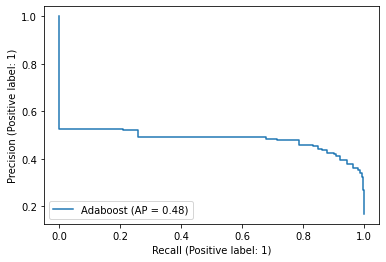

In [92]:
display = sklearn.metrics.PrecisionRecallDisplay.from_predictions(y_test, y_values, name="Adaboost")

In [89]:
best_weight

2

In [81]:
w1_vals = [1, 2, 5, 10, 20, 50]
proportion = len(y_train[y_train == 1])/len(y_train)

for w in w1_vals:

    adaboost = MyWeightedAdaboost(DecisionTreeClassifier(max_depth=1), 50, w)

    adaboost.fit(X_train, y_train)

    y_preds = adaboost.predict_proportion(X_test, proportion)

    # compute F1 score on test data
    (precision, recall, f1) = precision_recall_f1(y_preds, y_test)
    auprc = sklearn.metrics.average_precision_score(y_test, y_preds)

    print("Test precision: " + str(precision))
    print("Test recall: " + str(recall))
    print("Test F1 score: " + str(f1))
    print("Test AUPRC score: " + str(auprc)) 

63
64
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
0
0
2
2
219
219
219
219
0
0
0
2
2
219
219
211
219
219
2
2
89
0
219
219
2
2
219
219
219
219
211
219
Test precision: 0.4930103571226442
Test recall: 0.6795911998751756
Test F1 score: 0.5714566864565225
Test AUPRC score: 0.3875157006001298
63
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
64
63
0
0
219
219
219
219
2
2
219
219
211
219
219
219
219
0
0
2
2
89
0
0
0
219
219
2
63
35
219
219
0
Test precision: 0.49228874370782905
Test recall: 0.7171945701357466
Test F1 score: 0.5838308141750286
Test AUPRC score: 0.39937907996941097
63
2
2
2
2
0
0
2
2
2
2
0
0
211
211
2
2
0
2
2
219
219
219
219
2
2
219
0
0
219
211
219
219
0
0
0
89
2
219
219
0
219
219
2
2
219
219
211
219
219
Test precision: 0.49296264118158123
Test recall: 0.6639881416757685
Test F1 score: 0.5658345244822657
Test AUPRC score: 0.3823467079918321
63
2
2
2
2
0
0
2
2
0
0
2
2
211
211
2
2
0
219
219
2
2
219
219
219
0
0
0
2
2
0
219
219
211
219
219
89
64
2
63
2
219
219
0
219
219
219
219
211
219
Test precision: 

In [75]:
train_data.columns[211]

'Policy_Sales_Channel_151.0'

In [76]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=50)

adaboost.fit(X_train, y_train)

y_preds = adaboost.predict(X_test)

# compute F1 score on test data
(precision, recall, f1) = precision_recall_f1(y_preds, y_test)

print("Test precision: " + str(precision))
print("Test recall: " + str(recall))
print("Test F1 score: " + str(f1))

Test precision: 0.5426026850990296
Test recall: 0.3184584178498986
Test F1 score: 0.4013568654441768


In [26]:
for i in range(50):
    print(np.argmax(adaboost.estimators_[i].feature_importances_))

63
2
0
63
0
210
218
0
2
62
88
54
56
6
0
61
2
14
26
32
17
35
0
0
0
47
34
219
215
63
41
212
209
73
0
0
210
7
1
53
114
49
15
123
0
0
21
87
31
4


In [4]:
X = np.array([[0, 1], [2, 3], [4, 5]])
y = np.array([0, 0, 1])
print(X)
print(y)

[[0 1]
 [2 3]
 [4 5]]
[0 0 1]


In [5]:
samples = [0, 1, 0, 2]
X[samples]

array([[0, 1],
       [2, 3],
       [0, 1],
       [4, 5]])

In [6]:
y[samples]

array([0, 0, 0, 1])

In [48]:
y = np.array([1, -1, 1])

In [45]:
np.asarray(y == 1).nonzero()

(array([2], dtype=int64),)

In [49]:
np.where(y==1)

(array([0, 2], dtype=int64),)

In [47]:
y

array([-1, -1,  1])